In [1]:
import os.path as osp

import numpy as np

import time

from general_tools.in_out.basics import files_in_subdirs

from geo_tool import Point_Cloud

from external_tools.binvox_rw.binvox_rw import read_as_3d_array

from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.autoencoder import AutoEncoder, Configuration

import tensorflow as tf

from general_tools.notebook.tf import reset_tf_graph

from tflearn.layers.conv import conv_3d, conv_3d_transpose

from tf_lab.data_sets.numpy_dataset import NumpyDataset

In [2]:
%matplotlib inline
%autoreload 2

ERROR:root:Line magic function `%autoreload` not found.


In [3]:
top_voxel_dir = '/orions4-zfs/projects/optas/DATA/Voxels/ShapeNetVox32/'

class_name = 'chair'

syn_id = snc_category_to_synth_id()[class_name]

top_voxel_dir = osp.join(top_voxel_dir, syn_id) 

In [4]:
all_in_files = [f for f in files_in_subdirs(top_voxel_dir, '.binvox')]
n_shapes =  len(all_in_files)

In [5]:
def read_single_bin_vox(binvox_filename, perm_axis=(0,1,2)):
    with open(binvox_filename, 'rb') as f:
        vol = read_as_3d_array(f)
    
    vol = vol.data.astype(np.float32)
    vol = vol.transpose(perm_axis)
    vol = np.expand_dims(vol, 3)
    return vol

vol = read_single_bin_vox(all_in_files[0])
voxel_dims = list(vol.shape)

(128, 128, 128, 1)


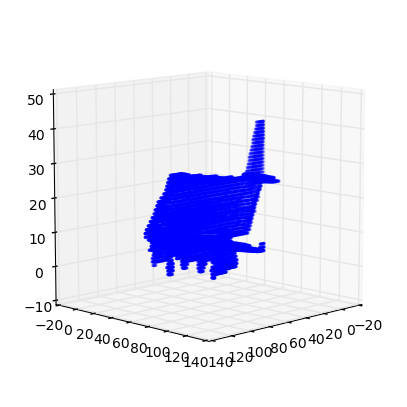

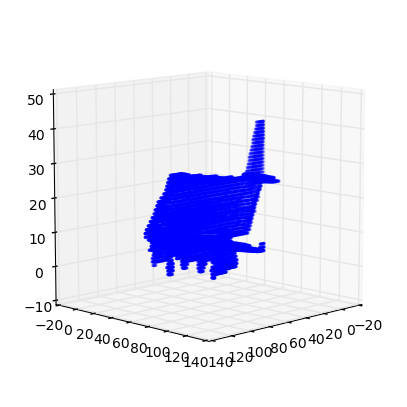

In [46]:
# yo = '/orions3-zfs/projects/msavva/zip/ShapeNetCore.v2/02691156/10155655850468db78d106ce0a280f87/models/model_normalized.solid.binvox'
yo = '/orions3-zfs/projects/msavva/zip/ShapeNetCore.v1/02691156/10155655850468db78d106ce0a280f87/model.binvox'
lala = read_single_bin_vox(yo, perm_axis=[0, 2, 1])
print lala.shape
lala = np.squeeze(lala)
x, y, z = np.where(lala >= 0.5)
Point_Cloud(np.vstack((x, y, z)).T).plot(in_u_sphere=False, azim=45)

In [42]:
lala.shape

(128, 128, 128, 1)

In [6]:
# TODO - parallel + train/test/val splits
all_data = np.zeros(shape=[n_shapes] + voxel_dims)
for i, f in enumerate(all_in_files):
    all_data[i] = read_single_bin_vox(f, perm_axis=[0, 2, 1])

In [7]:
train_data = NumpyDataset([all_data])
# Do we know if these voxels where acquired by "properly" scaled models?

['a']


In [8]:
def three_d_conv_encoder(in_signal):
    layer = conv_3d(in_signal, nb_filter=64, filter_size=8, strides=4, activation='relu')
    layer = conv_3d(layer, nb_filter=128, filter_size=6, strides=4, activation='relu')
    layer = conv_3d(layer, nb_filter=256, filter_size=4, strides=2, activation='relu')
    layer = conv_3d(layer, nb_filter=256, filter_size=2, strides=1, activation='relu')
    return layer


def three_d_conv_decoder(in_signal):
    layer = conv_3d_transpose(in_signal, nb_filter=256, filter_size=2, strides=1, output_shape=[1,1,1], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=128, filter_size=4, strides=2, output_shape=[2,2,2], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=64, filter_size=8, strides=4, output_shape=[8,8,8], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=1, filter_size=8, strides=4, output_shape=[32,32,32], activation='linear')
    return layer

In [9]:
class Voxel_Based_AE(AutoEncoder):    
    def __init__(self, name, configuration, graph=None):
        c = configuration
        self.configuration = c
        AutoEncoder.__init__(self, name, graph, configuration)
        self.z = c.encoder(self.x)
        self.x_reconstr = c.decoder(self.z)
        self._create_loss()
        init = tf.global_variables_initializer() # TODO -> make part of Neural_Net
        self.start_session()

    def _create_loss(self):
        self.loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.x, logits=self.x_reconstr)
        self.loss = tf.reduce_mean(self.loss)
        self._setup_optimizer()
        
    def _setup_optimizer(self):
        c = self.configuration
        self.lr = c.learning_rate
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        self.train_step = self.optimizer.minimize(self.loss)
        
    def _single_epoch_train(self, train_data, batch_size, only_fw=False):
        n_examples = train_data.n_examples
        epoch_loss = 0.
        n_batches = int(n_examples / batch_size)
        start_time = time.time()
        if only_fw:
            fit = self.reconstruct
        else:
            fit = self.partial_fit

        # Loop over all batches
        for _ in xrange(n_batches):
            batch_i = train_data.next_batch(batch_size)
            _, loss = fit(batch_i)
            # Compute average loss
            epoch_loss += loss
        epoch_loss /= n_batches
        duration = time.time() - start_time
        return epoch_loss, duration

In [10]:
conf = Configuration(n_input=voxel_dims, 
                     encoder=three_d_conv_encoder, 
                     decoder=three_d_conv_decoder,
                     learning_rate = 0.001
                    )

In [11]:
reset_tf_graph()
voxel_ae = Voxel_Based_AE('test_', conf)

In [12]:
for i in range(500):
    print i, voxel_ae._single_epoch_train(train_data, batch_size=128)[0]

0 0.379634539382
1 0.217480487835
2 0.188150891604
3 0.170143048637
4 0.15763573062
5 0.149665372016
6 0.145838368684
7 0.141719583995
8 0.134095520498
9 0.130043686439
10 0.125592912046
11 0.121375097965
12 0.115949318243
13 0.112966701102
14 0.108544075002
15 0.105598570206
16 0.104334909326
17 0.100977617674
18 0.0982343606078
19 0.0952900436062
20 0.0928489636057
21 0.0901790656723
22 0.0888544472937
23 0.0862555453697
24 0.0853618164189
25 0.0843399831882
26 0.0824464019388
27 0.080526921325
28 0.078656557231
29 0.0780606158078
30 0.0769490423397
31 0.0763268562464
32 0.0747428358747
33 0.0735507230633
34 0.0733828739478
35 0.071286059916
36 0.0701601442953
37 0.0692643595573
38 0.0688194861062
39 0.0689467205308
40 0.0676135883595
41 0.0666016690576
42 0.0662807994164
43 0.0644461172991
44 0.0631773097154
45 0.0622401993292
46 0.0612088923271
47 0.0604482374082
48 0.0601506195962
49 0.0597000726714
50 0.0591689986535
51 0.0589827857912
52 0.0591516531287
53 0.0578025679749
54 0.0

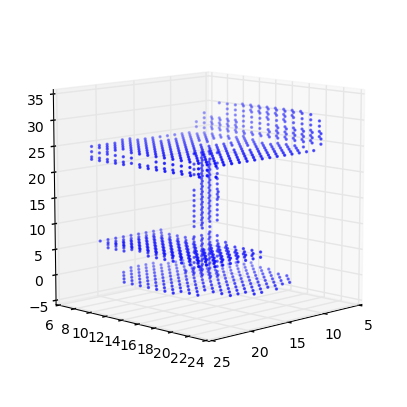

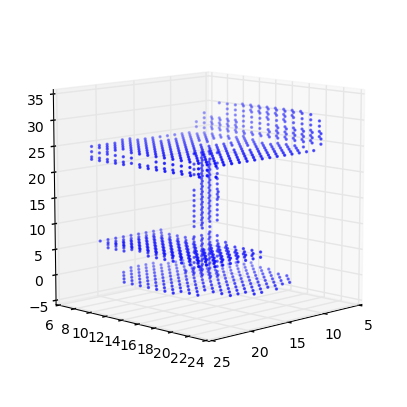

In [39]:
feed = train_data.next_batch(1)
yp = voxel_ae.reconstruct(train_data.next_batch(1))[0][0]
# yp.shape
lala = voxel_ae.sess.run(tf.sigmoid(yp))
lala = np.squeeze(lala)

x, y, z = np.where(lala >= 0.5)
Point_Cloud(np.vstack((x, y, z)).T).plot(in_u_sphere=False, azim=45)

In [13]:
x, y, z = np.where(np.squeeze(feed[0]) >= 0.5)
Point_Cloud(np.vstack((x, y, z)).T).plot(in_u_sphere=False)

NameError: name 'feed' is not defined

(array([ 0,  0,  0, ..., 31, 31, 31]),
 array([ 0,  0,  0, ..., 31, 31, 31]),
 array([ 0,  1,  2, ..., 29, 30, 31]),
 array([0, 0, 0, ..., 0, 0, 0]))

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


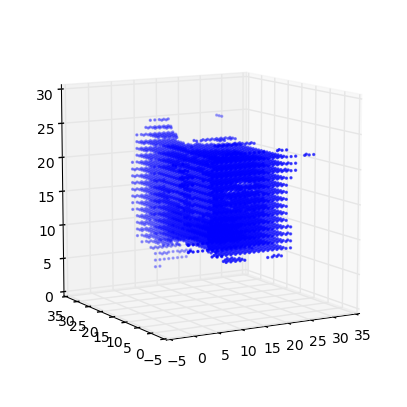

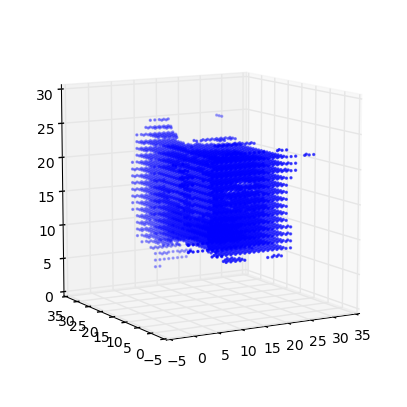